In [1]:
import os
import torch
import cv2
import matplotlib.pyplot as plt
import re
import numpy as np

In [2]:
data_path = "../data/"

data_channel_path = os.path.join(data_path, "data_channel")
rgb_channel_path = os.path.join(data_channel_path, "incoherent_RGBchannels")
rgb_channel_train_path = os.path.join(rgb_channel_path, "train_incoherent_RGBChannels")

### incoherent_RGBchannels

In [3]:
pattern = "Seg(\d+)_defocus(\-?\d+)"

In [4]:
segment_dict = {}
for segment_name in os.listdir(rgb_channel_train_path):
    segment_path = os.path.join(rgb_channel_train_path, segment_name)
    seg_dict = {}
    for image_name in os.listdir(segment_path):
        image_path = os.path.join(segment_path, image_name)
        match = re.search(pattern, image_name)
        if match:
            seg_num, defocus = int(match.group(1)), int(match.group(2))
            
        if seg_num not in seg_dict:
            seg_dict[seg_num] = []
        seg_dict[seg_num].append((defocus, image_path))
        
    segment_dict[segment_name] = seg_dict

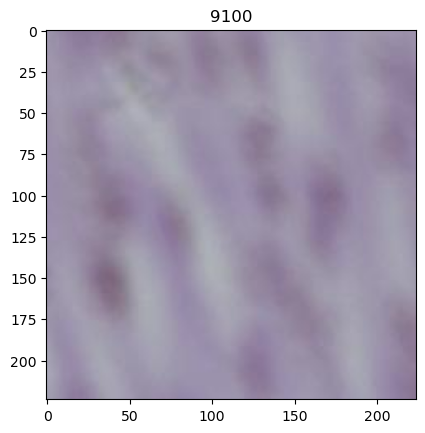

In [5]:
defocus, img_path = segment_dict["s93_l1"][2][np.random.randint(41)]
img = cv2.imread(img_path)
plt.title(defocus)
plt.imshow(img)

In [7]:
sorted(segment_dict["s93_l1"][2])

[(-10400,
  '../data/data_channel/incoherent_RGBchannels/train_incoherent_RGBChannels/s93_l1/Seg2_defocus-10400.jpg'),
 (-9900,
  '../data/data_channel/incoherent_RGBchannels/train_incoherent_RGBChannels/s93_l1/Seg2_defocus-9900.jpg'),
 (-9400,
  '../data/data_channel/incoherent_RGBchannels/train_incoherent_RGBChannels/s93_l1/Seg2_defocus-9400.jpg'),
 (-8900,
  '../data/data_channel/incoherent_RGBchannels/train_incoherent_RGBChannels/s93_l1/Seg2_defocus-8900.jpg'),
 (-8400,
  '../data/data_channel/incoherent_RGBchannels/train_incoherent_RGBChannels/s93_l1/Seg2_defocus-8400.jpg'),
 (-7900,
  '../data/data_channel/incoherent_RGBchannels/train_incoherent_RGBChannels/s93_l1/Seg2_defocus-7900.jpg'),
 (-7400,
  '../data/data_channel/incoherent_RGBchannels/train_incoherent_RGBChannels/s93_l1/Seg2_defocus-7400.jpg'),
 (-6900,
  '../data/data_channel/incoherent_RGBchannels/train_incoherent_RGBChannels/s93_l1/Seg2_defocus-6900.jpg'),
 (-6400,
  '../data/data_channel/incoherent_RGBchannels/train_